In [ ]:
!pip install emosent-py
!pip install emoji_extractor
!pip install emoji
!pip install vaderSentiment
from textblob import TextBlob
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('opinion_lexicon')
nltk.download('subjectivity')
nltk.download('vader_lexicon')
nltk.download('wordnet')

In [ ]:
import pandas as pd

Leemos y procesamos el diccionario de "Emoji Sentiment"

In [ ]:
# Preparar diccionario de emojis
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis negativos y entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

emoji_dict = load_emoji_sentiment("Emoji_Sentiment_Data_v1.0.csv")

# Extracción de sentimiento

Hemos comentado que se puede extraer la componente de sentimiento de varias formas:
- Con librerías externas que tienen modelos pre-entrenados (textblob)
- Con diccionarios de sentimiento (sentiment lexicons)
- A traves de los emojis presentes en el texto

In [ ]:
frase_no_emoji = "I love that my phone can just combine emojis. I don't like the lack of nice apps."
frase_emoji = "I love that my phone can just combine emojis 😍😺👏. I don't like the lack of nice apps."


## TextBlob

Esta librería es muy sencilla y algo similar a Spacy. A partir de un texto puedes calcular múltiples parámetros entre los que se encuentra el sentimiento. Para ello, sólo hay que importar la clase TextBlob que se aplica a nuestro texto, y después podríamos extraer el sentimiento que tiene: tanto la polaridad como la subjetividad:
```
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
testimonial.sentiment
```



In [ ]:
frase_no_emoji_blob = TextBlob(frase_no_emoji)
frase_emoji_blob = TextBlob(frase_emoji)
print(frase_no_emoji_blob.sentiment)
print(frase_emoji_blob.sentiment)

Sentiment(polarity=0.55, subjectivity=0.8)
Sentiment(polarity=0.55, subjectivity=0.8)


TextBlob omite el emoticono. Podríamos sustituirlo por una frase utilizando un conversor. PAra eso hay que extraer el emoji y sustituirlo por su descripción:


In [ ]:
from emoji_extractor.extract import Extractor
extract = Extractor()
emojis = extract.count_emoji(frase_emoji, check_first=False)
emojis_list = [key for key, _ in emojis.most_common()]
emojis_list


['😍', '😺', '👏']

Hemos extraid emojis de un texto, ahora vamos a sustituirlos por su descripción con la librería "emoji":

In [ ]:
import emoji
import string
emojis_description = emoji.demojize( " ".join(emojis_list))
emojis_desc_final = emojis_description.replace(":","")
emojis_desc_final = emojis_desc_final.replace("_"," ")
emojis_desc_final


'smiling face with heart-eyes grinning cat clapping hands'

Lematizamos (también podemos con Text Blob!)

In [ ]:
from textblob import Word 
emojis_blob = emojis_desc_final.split()
emojis_lemmas = [Word(x).lemmatize("v") for x in emojis_blob]
emojis_lemmas = " ".join(emojis_lemmas)
emojis_lemmas

'smile face with heart-eyes grin cat clap hand'

In [ ]:
final_emoji_sentence = TextBlob(frase_emoji+ " " +emojis_lemmas)
print(frase_no_emoji_blob.sentiment)
print(final_emoji_sentence.sentiment)

Sentiment(polarity=0.55, subjectivity=0.8)
Sentiment(polarity=0.46666666666666673, subjectivity=0.5666666666666668)


El valor de la polaridad es menor, porque aunque el token "smile tiene una polaridad positiva" el resto de token introducidos no tienen sentimiento, por lo que el promedio baja.

También se pueden utilizar la librería NLTK para algo similar con la función 'nltk.sentiment.util.demo_liu_hu_lexicon(frase_emoji)', que devuelve un valor de "positivo","negativo" o "neutro".

In [ ]:
from nltk.sentiment.vader import SentiText,SentimentIntensityAnalyzer #https://github.com/cjhutto/vaderSentiment
sentsss=SentimentIntensityAnalyzer()
sentsss

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
print(sentsss.polarity_scores(frase_emoji))
print(sentsss.polarity_scores(frase_no_emoji))

{'neg': 0.091, 'neu': 0.52, 'pos': 0.388, 'compound': 0.7815}
{'neg': 0.096, 'neu': 0.498, 'pos': 0.406, 'compound': 0.7815}


Positive


/usr/local/lib/python3.7/dist-packages/nltk/sentiment/util.py:252: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  axes = plt.axes()
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128079 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128079 missing from current font.
  font.set_text(s, 0, flags=flags)


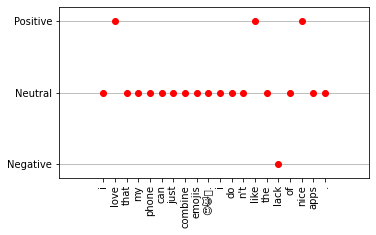

In [ ]:
from nltk.sentiment.util import demo_liu_hu_lexicon
demo_liu_hu_lexicon(frase_emoji,plot=True)